# Introduction
The bike has 20 gears but the power has a linear relationship to the speed. The cadence doesn't matter. So the observed speed could be as as a feature with a linear model of any tacx data set (data sets of any gear).


# Problem
Question: The tacx data set has a high standard deviation of the speed for each power value. The reason is that the tacx app adjusts speed with a delay if the cadence changes (this shall simulate that the bie is rolling if you stop pedaling). 

# Solution
The idea is to find the cluster of oberservations in the data set which have  

_Train data (app data):
* X of app data set -> [cadence, speed]
* Y -> [selected gear]

## Pre processing


In [121]:
import pandas as pd

from src.tcx import Tcx, COLUMN_NAME_SPEED, COLUMN_NAME_WATTS, COLUMN_NAME_CADENCE
from src.test_data import TrainDataSet

tcx_app_gear7: Tcx = Tcx.read_tcx(file_path='test/tcx/cadence_1612535177298-gear7.tcx')
tcx_app_gear20: Tcx = Tcx.read_tcx(file_path='test/tcx/cadence_1612535671464-gear20.tcx')
tcx_tacx_gear7: Tcx = Tcx.read_tcx(file_path='test/tcx/tacx-activity_6225123072-gear7-resistance3.tcx')
tcx_tacx_gear20: Tcx = Tcx.read_tcx(file_path='test/tcx/tacx-activity_6225123072-gear7-resistance3.tcx')

# generate test data
dts_gear7: TrainDataSet = TrainDataSet(tcx_app_gear7)
dts_gear20: TrainDataSet = TrainDataSet(tcx_app_gear20)
dts_tacx_gear7: TrainDataSet = TrainDataSet(tcx_tacx_gear7)

## Linear regression
To find out we create a linear model from the tacx data with differetn features and calculate a score for each tacx cadence value to see whether the model predicts the velocity good enough.

### Cadence
_X_ = [cadence], _y_ = power

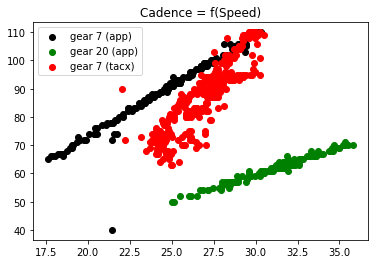

In [122]:
from functools import reduce

from sklearn.model_selection import train_test_split
from sklearn.linear_model._base import LinearModel

import matplotlib.pyplot as plt



def plot2d(X_train: pd.Series, y_train: pd.Series, point_color='black', legend_label='unknown') -> None:
    # Plot X_train -> y_train
    plt.scatter(X_train, y_train,  color=point_color, label=legend_label)
    plt.title("{} = f({})".format(y_train.name, X_train.name))
    plt.xticks()
    plt.yticks()
    plt.legend()

# === gear 7
X, y = dts_gear7.cadence_to_speed()
plot2d(y, X.iloc[:,0], legend_label='gear 7 (app)')
X, y = dts_gear20.cadence_to_speed()
plot2d(y, X.iloc[:,0], point_color='green', legend_label='gear 20 (app)')

X, y = dts_tacx_gear7.cadence_to_speed()
plot2d(y, X.iloc[:,0], point_color='red', legend_label='gear 7 (tacx)')

plt.show()
plt.close()

# Find X(cad/speed) in tacx in cluster of X(cad/speed) in app data

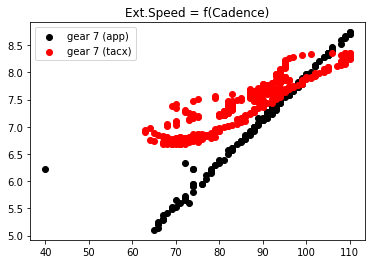

In [123]:
X, y = dts_gear7.cadence_to_externalspeed()
plot2d(X.iloc[:, 0], y, point_color='black', legend_label='gear 7 (app)')
X, y = dts_tacx_gear7.cadence_to_externalspeed()
plot2d(X.iloc[:, 0], y, point_color='red', legend_label='gear 7 (tacx)')


Scaling with min-max should bring the linear parts of the two data sets over each other. So we can see whether there are two groups of observations.

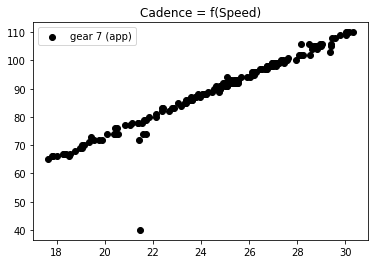

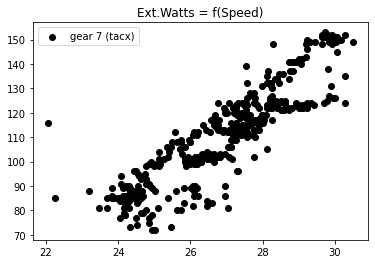

In [124]:
from sklearn.preprocessing import MinMaxScaler

def scale(*args: pd.Series):
    return (MinMaxScaler().fit_transform(X) for X in args)

X, y = dts_gear7.cadence_to_speed()
# X_scaled, y_scaled = scale(X, y)
plot2d(y, X.iloc[:, 0], point_color='black', legend_label='gear 7 (app)')
plt.show()

X, y = dts_tacx_gear7.speed_to_power()
# X_scaled, y_scaled = scale(X, y)
plot2d(X.iloc[:, 0], y , point_color='black', legend_label='gear 7 (tacx)')
plt.show()